# Свёрточные нейронные сети (Convolutional Neural Networks, CNN)

Хайпу и шумихе в СМИ вокруг нейросети обязаны именно свёрточным архитектурам. Свёрточные нейронные сети (СНС) *качественно* превосходят прочие алгоритмы компьютерного зрения в задачах распознавания образов, сегментации, детектирования, а так же имеют совершенно экзотические применения, которые не под силу другим алгортимам. Например:

<h2>DeepFake</h2>
<center><img src='img/deepfake.jpg' width=600></center>

<h2>DeepDream</h2>
<center><img src='img/deepdream.jpg' width=600></center>

<h2>Prisma</h2>
<center><img src='img/prisma.jpg' width=600></center>

<h2>Подмена погоды (вообще, тут скорее спасибо GAN):</h2>
<center><img src='img/nvidia.jpg' width=600></center>

Впервые нейронные сети привлекли всеобщее внимание в 2012 году, когда Алекс Крижевски благодаря им выиграл конкурс ImageNet, снизив рекорд ошибок классификации с 26% до 15%, что, в принципе, переход совсем на новый уровень. Свёрточная архитектура неспроста так хороша в задачах обработки изображений, посольку концепция была подсмотрена у природы - прямо из зрительной коры животных. За подробностями обращаться к поисковику, отправная точка - запросы *Дэвид Хьюбел* и *Торстен Визель*. 

## Свёртка

Свёрточные сети называются свёрточными, потому, что их слои применяют *операцию свёртки* к изображению. Рассмотрим один из каналов изображения как матрицу (коей он и является). Возьмём ещё одну небольшую матрицу, обычно размерами 3х3 или 5х5, которая называется фильтром (filter) или ядром свёртки (kernel). *Результатом свёртки будет ещё одна матрица*, элементы которой вычисляются следующим образом: верхний левый элемент (0, 0) результирующий матрицы, это сумма поэлементного произведения фильтра на элементы исходной матрицы, которые находятся в левом верхнем углу:

<center><img src='img/conv.png' width=600></center>

Остальные элементы результирующей матрицы получаются сдвигом фильтра по исходной. То есть, элемент (0, 1) - это сумма произведений элементов фильтра на элементы минора (1:4, 0:3) исходной матрицы. Приведённый в примере фильтр является детектором вертикальных границ. Реализуем функцию свёртки и посмотрим, как это работает с различными фильтрами, в т.ч. и с детектором вертикальных границ. В качестве исходной картинки возьмём такую:

<center><img src='img/zebra.jpg'></center>

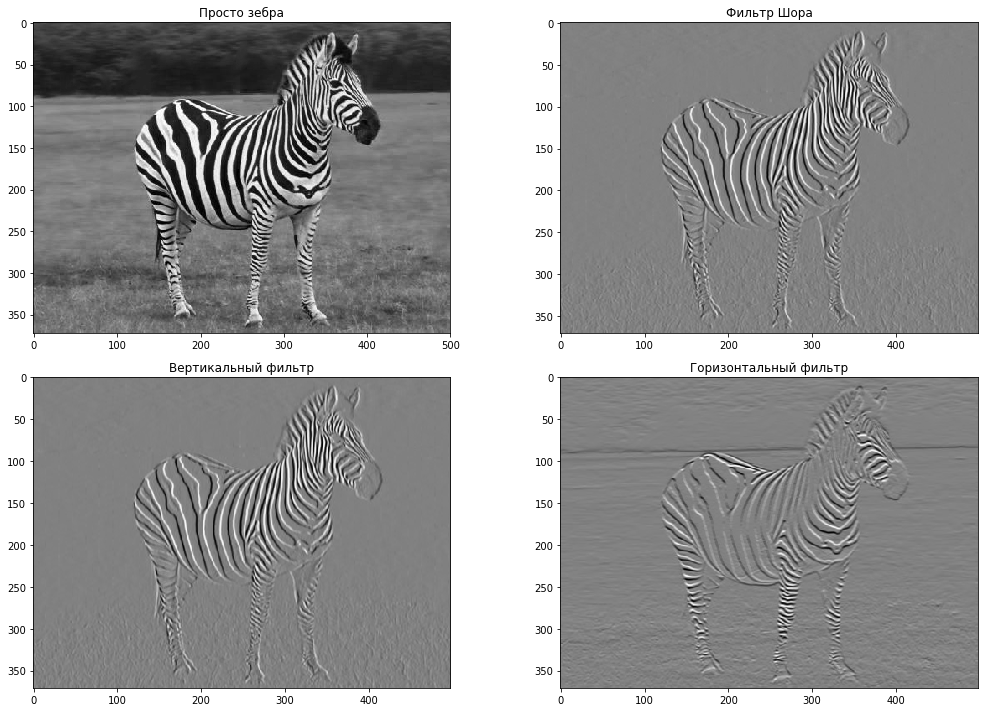

In [57]:
import numpy as np
import matplotlib.pyplot as plt

def convolution(x, kernel):
    f = kernel.shape[0]
    shape = np.array(x.shape) - (f - 1)
    result = np.zeros(shape=shape)
    for i in range(0, result.shape[0]):
        for j in range(0, result.shape[1]):
            result[i, j] = np.sum(x[i:i+f, j:j+f] * kernel)
    
    return result

x = plt.imread('img/zebra.jpg')[..., 0]

vkernel = np.array([[1, 0, -1], 
                    [1, 0, -1], 
                    [1, 0, -1]])  # Фильтр с картинки выше

hkernel = np.array([[1, 1, 1], 
                    [0, 0, 0], 
                    [-1, -1, -1]])  # Аналогичный ему детектор горизонтальных границ

shorr_kernel = np.array([[3, 0, -3], 
                         [10, 0, -10], 
                         [3, 0, -3]])  # Фильтр Шора, детектор вертикальных и горизонтальных границ

vresult = convolution(x, vkernel)
hresult = convolution(x, hkernel)
shorr_result = convolution(x, shorr_kernel)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
imgs = [x, shorr_result, vresult, hresult]
titles =  ['Просто зебра', 'Фильтр Шора', 'Вертикальный фильтр', 'Горизонтальный фильтр']

for ax, img, title, in zip(axes, imgs, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)

plt.tight_layout()

Что-то похожее было выявлено в экспериментах Хьюбела и Визеля. Они обнаружили, что одна группа нейронов активируется, когда на сетчатку попадает изображение, с резкой вертикальной границей, другая - когда с резкой горизонтальной, третья - когда граница диагональная, четвёртая - когда диагональная, но с другим наклоном и так далее. И именно подражание такой структуре, обнаруженной в зрительной коре животных, привело к созданию свёрточных нейросетей и впечатляющим результатам в задачах распознавания образов.

Во время обучения нейросети подбирается определённый набор фильтров, который лучше всего соответствует задаче. Вот пример набора фильтров первого свёрточного слоя обученной на ImageNet сети. 

<center><img src='img/filters.png'></center>

Обратим внимание на то, что фильтры содержат цветовую компоненту. Это значит, что используют не плоские фильтры, а трёхмерные: то есть, не (5x5), а (5x5x3).

# Pooling слои

Так же СНС содержат ещё один вид слоёв - *pooling* слои. В русскоязычной терминологии нет устоявшегося названия для таких слоёв, встречаются варианты "подвыборочный" или "субдискретизирующий" слои. Однако, чаще всего вы будете встречать их под именами "pooling" или даже "пулинг" слои. Цель такого слоя – уменьшение размерности предыдущих слоёв. Если на предыдущей операции свертки уже были выявлены некоторые признаки, то для дальнейшей обработки настолько подробное изображение уже не нужно, и оно уплотняется до менее подробного.

Уплотнение достигается путём разбиения слоя на равные непересекающиеся группы. Например, пулинг с ядром (2х2), уплотнит слой в два раза. В дальнейшем к элементам этой группы применяется некоторая функция, которая отображает всю группу в одно число. Например, слой MaxPooling выбирает из всей группы максимальный элемент:

<center><img src='img/maxpool.png'></center>

Опять же, структуры, подобные пулинг слоям, были найдены в зрительной коре животных теми же Хьюбелом и Визелем.

# Параметры слоёв

Convolutional и Pooling слои имеют параметры `kernel`, `stride` и `padding`, которые характеризуют их поведение.

## kernel / filter
Этот параметр отвечает за размер ядра свёртки.

### kernel=3
<center><img src='img/filter3.png' width=300></center>

### kernel=4
<center><img src='img/filter4.png' width=300></center>

---

## stride
Этот параметр указывает, на сколько должно смещаться ядро на каждом шаге. По умолчанию для свёртки `stride=1`, а для пулинга `stride=kernel.shape`.

### stride=1
<center><img src='img/stride1.png' width=500></center>

### stride=3
<center><img src='img/stride3.png' width=500></center>

---
## padding
Этот параметр указывает на размер рамки вокруг исходного изображения. Рамку добавляют чтобы сохранить исходный размер. Значение параметра определяет толщину рамки. Keras не позволяет задавать параметр в явном виде, а имеет два режима - `"valid"` и `"same"`. `"valid"` - отсутствие рамки, `"same"` - толщина рамки подбирается таким образом, чтобы после применения фильтра изображение сохранило исходный размер.

### padding=1
<center><img src='img/padding1.png' width=400></center>

# Размер результирующего слоя

Разумеется, от значения параметров изменяется размер результирующего слоя. Общая формула для размера результирующего слоя:

$$(x, y) \rightarrow (\frac{x + 2p - f_x}{s} + 1, \frac{y + 2p - f_y}{s} + 1),$$

где $x$ и $y$ - размеры исходного слоя, $p$ - значение параметра `padding`, $s$ - значение параметра `stride`, а $f_x$ и $f_y$ - размеры `kernel`.

Количество каналов на выходе совпадает с количеством фильтров на слое.